In [1]:
import sys
sys.path.append('/home/msuleman/ml20_scratch/fyp_galaxy')

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from modules.dataset import SAMDataset
from modules.model import SAMWrapper

from transformers import SamProcessor, SamModel

from tqdm import tqdm

/home/msuleman/ml20_scratch/msul0021/miniconda/conda/envs/fyp_dinov2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = TF.to_pil_image(img)
        img = np.asarray(img)
        axs[0, i].imshow(img)

In [4]:
device = torch.device("cuda:0")

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")
model = SAMWrapper(model)

root, annFile = '../data/val', '../data/annotations/val.json'
valset = SAMDataset(root, annFile, processor)
valloader = DataLoader(valset, batch_size=5, shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
model.setDevice(device)

preds, truth = [], []
with torch.no_grad():
    for batch in tqdm(valloader):
            pixVal, inBox = batch['pixel_values'], batch['input_boxes']
            lbl, gT = batch['input_labels'], batch['ground_truth_mask']
            
            pixVal, inBox = pixVal.to(device), inBox.to(device)
            lbl, gT = lbl.to(device), gT.to(device)

            logit, gT = model(pixVal, inBox, lbl, gT)
            
            preds.append(logit.detach().cpu())
            truth.append(gT.cpu())

preds = torch.concatenate(preds)
truth = torch.concatenate(truth)

100%|██████████| 84/84 [04:02<00:00,  2.88s/it]


In [6]:
from torchmetrics.functional.classification import binary_jaccard_index, binary_accuracy

iou = binary_jaccard_index(preds, truth)
acc = binary_accuracy(preds, truth)

print(iou)
print(acc)

tensor(0.7925)
tensor(0.9992)


In [10]:
truth.shape

torch.Size([631, 450, 450])

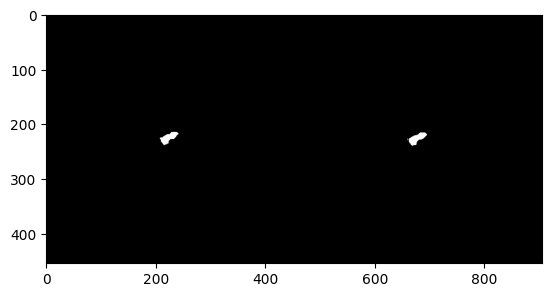

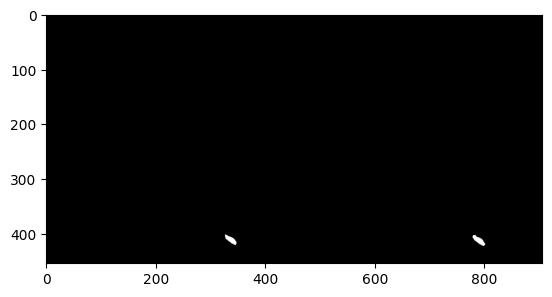

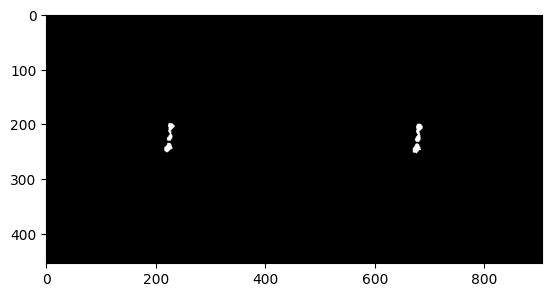

In [14]:
from torchvision.utils import make_grid

idx = [0, 30, 50]

for i in idx:
    t = torch.unsqueeze(truth[i], dim=0)
    p = torch.unsqueeze(preds[i], dim=0)
    p = F.sigmoid(p)

    grid = make_grid([t, p])
    show(grid)